Test & visualize some trained segmentation algs

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import cv2
import numpy as np
import sys, os, shutil, glob, time, random

sys.path.insert(0, '/home/nathan/caffe-segnet-crf/python')
# sys.path.insert(0, '/home/nathan/caffe-segnet-cudnn5/python')
# sys.path.insert(0, '/home/nathan/tmp/caffe-denseimagedata/python')
import caffe

sys.path.insert(0, '/home/nathan/histo-seg/v2/core')
import colorNormalization as cnorm

####################
#                  #
#                  #
caffe.set_mode_gpu()
# caffe.set_mode_cpu()
#                  #
#                  #
####################


%matplotlib inline
from matplotlib import pyplot as plt

# Run many & save RGB

In [7]:
def colorize(mask, colors):
    r = np.zeros(mask.shape, dtype=np.uint8)
    g = np.zeros(mask.shape, dtype=np.uint8)
    b = np.zeros(mask.shape, dtype=np.uint8)
    for u in np.unique(mask):
#         print 'Replacing {} with {}'.format(u, colors[u,:])
        r[mask==u] = colors[u, 0]
        g[mask==u] = colors[u, 1]
        b[mask==u] = colors[u, 2]
        
    return np.dstack([r,g,b])

# def replace_eric_labels(mask, label_levels):
#     mask_out = np.copy(mask)
#     for key in label_levels.iterkeys():
#         mask_out[mask == key] = label_levels[key]
        
#     return mask_out

expt = 'xval_set_0_10X_SegNet_CRF'
imgsource = 'xval_set_0'
dataset = 'xval_set_0_512'
size = 600

# prototxt = '/home/nathan/histo-seg/semantic-pca/code/proto/segnet_basic_deploy_merged_10X.prototxt'
# weights = '/home/nathan/histo-seg/semantic-pca/weights/xval_set_0_512/batchnorm_merged_segnet_basic_pca.caffemodel'

# prototxt = '/home/nathan/histo-seg/semantic-pca/code/segnet_basic_crfrnn_deploy_5X.prototxt'
# weights = '/home/nathan/histo-seg/semantic-pca/weights/{}/batchnorm_segnet_basic_crf_pca_20170712.SGD_iter_25000.caffemodel'.format(dataset)

prototxt = '/home/nathan/histo-seg/semantic-pca/code/segnet_crfrnn_deploy_10X.prototxt'
weights = '/home/nathan/histo-seg/semantic-pca/weights/{}/segnet_crf_pca_20170726_iter_100000.caffemodel'.format(dataset)

# prototxt = '/home/nathan/histo-seg/semantic-pca/code/segnet_deploy_10X.prototxt'
# weights = '/home/nathan/histo-seg/semantic-pca/weights/{}/batchnorm_segnet_pca_75000.caffemodel'.format(dataset)

# prototxt = '/home/nathan/histo-seg/semantic-pca/code/fcn8s_deploy_5X.prototxt'
# weights = '/home/nathan/histo-seg/semantic-pca/weights/{}/fcn_8s_PASCAL.caffemodel'.format(dataset)

net = caffe.Net(prototxt, weights, caffe.TEST)

img_list = sorted(glob.glob('/home/nathan/histo-seg/semantic-pca/data/{}/val/jpg/*.jpg'.format(imgsource)))
mask_list = sorted(glob.glob('/home/nathan/histo-seg/semantic-pca/data/{}/val/mask/*.png'.format(imgsource)))
print 'Img list: ', len(img_list)
print 'Mask list: ', len(mask_list)

colors = np.array([
    [235, 45, 35],
    [99, 220, 77],
    [55, 55, 230],
    [240, 240, 240]
])

outdir = '/home/nathan/histo-seg/semantic-pca/figures/net_outputs/{}'.format(expt)
if not os.path.exists(outdir):
    os.makedirs(outdir)
layer = 'prob'

idx = 1
timestart = time.time()
for img_name, mask_name in zip(img_list, mask_list):
#     img_name = img_list_shuffled[index]
    img_base = os.path.basename(img_name)

    img = cv2.imread(img_name)
    img = cv2.resize(img, dsize=(size, size))
    img = cnorm.normalize(img)
    img_og = np.copy(img)
    img = img.transpose((2,0,1))
    img = np.expand_dims(img, 0)

    _ = net.forward(data = img)
    seg = np.argmax(net.blobs[layer].data[0,...], 0)
    seg = colorize(seg, colors)
    
    mask = cv2.imread(mask_name, 0)
    mask = cv2.resize(mask, dsize=(size, size), interpolation=cv2.INTER_NEAREST)
    mask = colorize(mask, colors)
    
    img_og = cv2.copyMakeBorder(img_og,10,10,10,10,cv2.BORDER_CONSTANT,value=0)
    seg = cv2.copyMakeBorder(seg,10,10,10,10,cv2.BORDER_CONSTANT,value=0)
    mask = cv2.copyMakeBorder(mask,10,10,10,10,cv2.BORDER_CONSTANT,value=0)
    img_out = np.hstack([img_og, seg, mask])
    
    cv2.imwrite(os.path.join(outdir, img_base), img_out)
#     cv2.imwrite(os.path.join(outdir, img_base.replace('.jpg', '_.jpg')), seg)
    
    tdelta = time.time() - timestart
    idx += 1
    if idx % 250 == 0:
        print '{} ({:3.3f}s)'.format(idx, tdelta)

tdelta = time.time() - timestart
print 'Done in {}s'.format(tdelta)
print '{} img/s'.format(float(len(img_list)) / tdelta)

Img list:  103
Mask list:  103
Done in 33.0806260109s
3.1136049229 img/s


# Write out a bunch of masks for numbers

In [5]:
# outdir = '../figures/segnet_512_mask'

datasets = ['xval_set_0',
            'xval_set_1',
            'xval_set_2',
            'xval_set_3',
            'xval_set_4']
appendage = '_1024'
size = 300
mag = '5X'
layer = 'prob'
out_root = '/home/nathan/histo-seg/semantic-pca/analysis_segnet_basic'
prototxt = '/home/nathan/histo-seg/semantic-pca/code/segnet_basic_deploy_{}.prototxt'.format(mag)

for dataset in datasets:
    weights = '/home/nathan/histo-seg/semantic-pca/weights/{}/batchnorm_segnet_basic_pca.caffemodel'.format(dataset+appendage)

    net = caffe.Net(prototxt, weights, caffe.TEST)

    img_list = sorted(glob.glob('/home/nathan/histo-seg/semantic-pca/data/{}/val/jpg/*.jpg'.format(dataset)))
    mask_list = sorted(glob.glob('/home/nathan/histo-seg/semantic-pca/data/{}/val/mask/*.png'.format(dataset)))
    print dataset
    print 'Img list: ', len(img_list)
    print 'Mask list: ', len(mask_list)

    outdir = os.path.join(out_root, '{}'.format(dataset+appendage))
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    idx = 1
    timestart = time.time()
    for img_name in img_list:
        img_base = os.path.basename(img_name).replace('jpg', 'png')

        img = cv2.imread(img_name)
        img = cv2.resize(img, dsize=(size, size))
        img = cnorm.normalize(img)
    #     img = img[:,:,::-1]
        img = img.transpose((2,0,1))
        img = np.expand_dims(img, 0)

        _ = net.forward(data = img)
    #     seg = np.argmax(net.blobs['conv1_1_D'].data[0,...], 0)
        seg = np.argmax(net.blobs[layer].data[0,...], 0)

        cv2.imwrite(os.path.join(outdir, img_base), seg)

        tdelta = time.time() - timestart
        idx += 1
        if idx % 50 == 0:
            print '{:04d} ({:3.3f}s)'.format(idx, tdelta)

    
    tdelta = time.time() - timestart
    timestr = dataset + appendage + '\n' + 'Done in {}s\n'.format(tdelta) + '{} img/s\n'.format(float(len(img_list)) / tdelta)
    print timestr
    
    with open(os.path.join(out_root, '{}_timeprofile.txt'.format(dataset+appendage)), 'w+') as f:
        f.write(timestr)
#     print dataset
#     print 'Done in {}s'.format(tdelta)
#     print '{} img/s'.format(float(len(img_list)) / tdelta)
    
    

xval_set_0
Img list:  103
Mask list:  103
0050 (5.145s)
0100 (10.296s)
xval_set_0_1024
Done in 10.7114470005s
9.61588102851 img/s

xval_set_1
Img list:  103
Mask list:  103
0050 (5.290s)
0100 (10.415s)
xval_set_1_1024
Done in 10.8649270535s
9.48004524037 img/s

xval_set_2
Img list:  102
Mask list:  102
0050 (5.312s)
0100 (9.890s)
xval_set_2_1024
Done in 10.1580691338s
10.0412783824 img/s

xval_set_3
Img list:  102
Mask list:  102
0050 (4.527s)
0100 (8.999s)
xval_set_3_1024
Done in 9.28752207756s
10.982477258 img/s

xval_set_4
Img list:  103
Mask list:  103
0050 (4.576s)
0100 (8.934s)
xval_set_4_1024
Done in 9.31234407425s
11.0605878798 img/s



# Run one

0.015 0 3
1.005 0 3
1.995 0 3
2.985 0 3


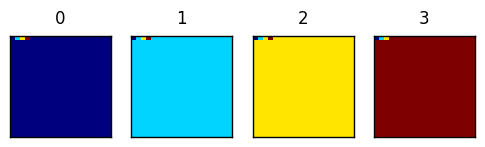

In [2]:
def add_dummy_pix(img, n = 4):
    for k in range(n):
        img[0, k] = k
    return img

# Print a color code
def plot_colorcode(n= 4):
    x = np.zeros([20,20], dtype=np.uint8)
    
    fig, ax= plt.subplots(1, 4)
    for k in range(n):
        x_ = np.copy(x)
        x_ = add_dummy_pix(x_ + k)
        print x_.mean(), x_.min(), x_.max()
        ax[k].matshow(x_)
        ax[k].set_title(k)
        ax[k].set_xticks([])
        ax[k].set_yticks([])
    
plot_colorcode()

def plot_from_net(img_list, net, layer=['conv1_1_D'], img_index=None):
    
    assert isinstance(layer, list), 'layer must be a list of layer names'
    
    if img_index is not None:
        index = img_index
    else:
        index = np.random.randint(len(img_list))
        
    print img_list[index]

    mask = cv2.imread(mask_list[index], 0)
    mask = add_dummy_pix(mask)

    print img_list[index], mask_list[index]

    img = cv2.imread(img_list[index])
    img_og = np.copy(img)
    img = img.transpose((2,0,1))
    img = np.expand_dims(img, 0)

    net_time = time.time()
    _ = net.forward(data = img)
    print 'Net finish in {}s'.format(time.time() - net_time)

    segs = []
    for lay in layer:
        seg = np.argmax(net.blobs[lay].data[0,...], 0)
        segs.append(add_dummy_pix(seg))
    
    fig, axs = plt.subplots(1,len(layer)+2, figsize=(15,7))
    axs[0].imshow(img_og[:,:,::-1])
    axs[0].set_xticks([]); axs[0].set_yticks([])
    axs[0].set_title('H&E')
                    
    for ax, lay, seg in zip(axs[1:-1], layer, segs):
        ax.matshow(seg)
        ax.set_xticks([]); axs[1].set_yticks([])
        ax.set_title('{}'.format(lay))
    
    axs[-1].matshow(mask)
    axs[-1].set_xticks([]); axs[2].set_yticks([])
    axs[-1].set_title('Ground Truth')
 
    print seg.dtype, seg.shape, seg.min(), seg.max()

    return net, index, fig
    
def plot_filters_activations(net, layer='conv1_1', mode='f', subset=None):
    if mode == 'f':
        x = np.squeeze(net.params[layer][0].data[:,0,:,:])
        print 'Filters: shape={}'.format(x.shape)
    elif mode == 'a':
        x = np.squeeze(net.blobs[layer].data[0,...])
        
        if subset is not None and x.shape[0] > subset:
            idx = np.random.choice(range(x.shape[0]), subset)
            x = x[idx, :,:]
        print 'Activations: shape={}'.format(x.shape)
    else:
        print 'what'
        return 0

    x = (x - x.min()) / (x.max() - x.min())
    h = x.shape[1]
    s = int(np.floor(np.sqrt(x.shape[0])))
    x = x[:s**2, ...]

    #Blood magic from shelhamer
    padding = (((0, s ** 2 - x.shape[0]),
               (0, 5), (0, 5))                 # add some space between filters
               + ((0, 0),) * (x.ndim - 3))     # don't pad the last dimension (if there is one)
    x = np.pad(x, padding, mode='constant', constant_values=1)  # pad with ones (white)
    x_ = x.reshape((s, s) + x.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, x.ndim + 1)))
    x_ = x_.reshape((s * x_.shape[1], s * x_.shape[3]) + x_.shape[4:])
    
    print 'x_ plotting: {}'.format(x_.shape), x_.min(), x_.max()

    fig, ax=  plt.subplots(1,1, figsize=(13,13))
    ax.matshow(x_, cmap='jet')
    ax.set_xticks([])
    ax.set_yticks([])
    
    return fig

In [37]:
prototxt = '/home/nathan/histo-seg/semantic-pca/code/segnet_crfrnn_deploy.prototxt'
weights = '/home/nathan/histo-seg/semantic-pca/weights/xval_set_0_512/batchnorm_segnet_crf_pca_100000.caffemodel'

imgsource = 'xval_set_0_512'
img_list = sorted(glob.glob('/home/nathan/histo-seg/semantic-pca/data/{}/val/jpg/*.jpg'.format(imgsource)))
mask_list = sorted(glob.glob('/home/nathan/histo-seg/semantic-pca/data/{}/val/mask/*.png'.format(imgsource)))
print 'Img list: ', len(img_list)
print 'Mask list: ', len(mask_list)
net = caffe.Net(prototxt, weights, caffe.TEST)

Img list:  1236
Mask list:  1236


/home/nathan/histo-seg/semantic-pca/data/xval_set_0_512/val/jpg/0497_512ssscc.jpg
/home/nathan/histo-seg/semantic-pca/data/xval_set_0_512/val/jpg/0497_512ssscc.jpg /home/nathan/histo-seg/semantic-pca/data/xval_set_0_512/val/mask/0497_512ssscc.png
Net finish in 0.139677047729s
int64 (256, 256) 0 3
Activations: shape=(4, 256, 256)
x_ plotting: (522, 522) 0.0 1.0


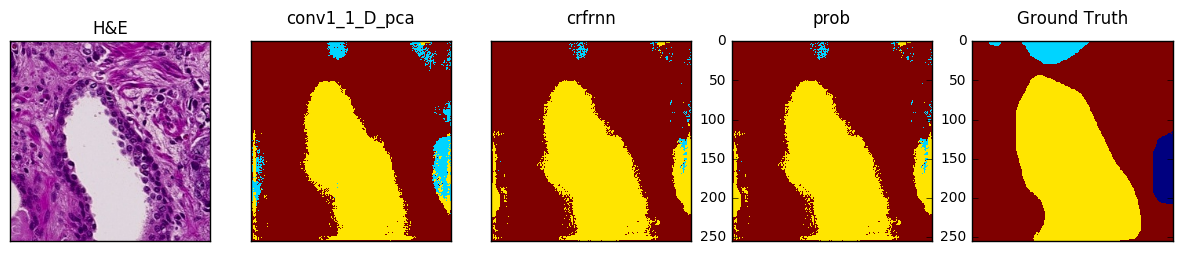

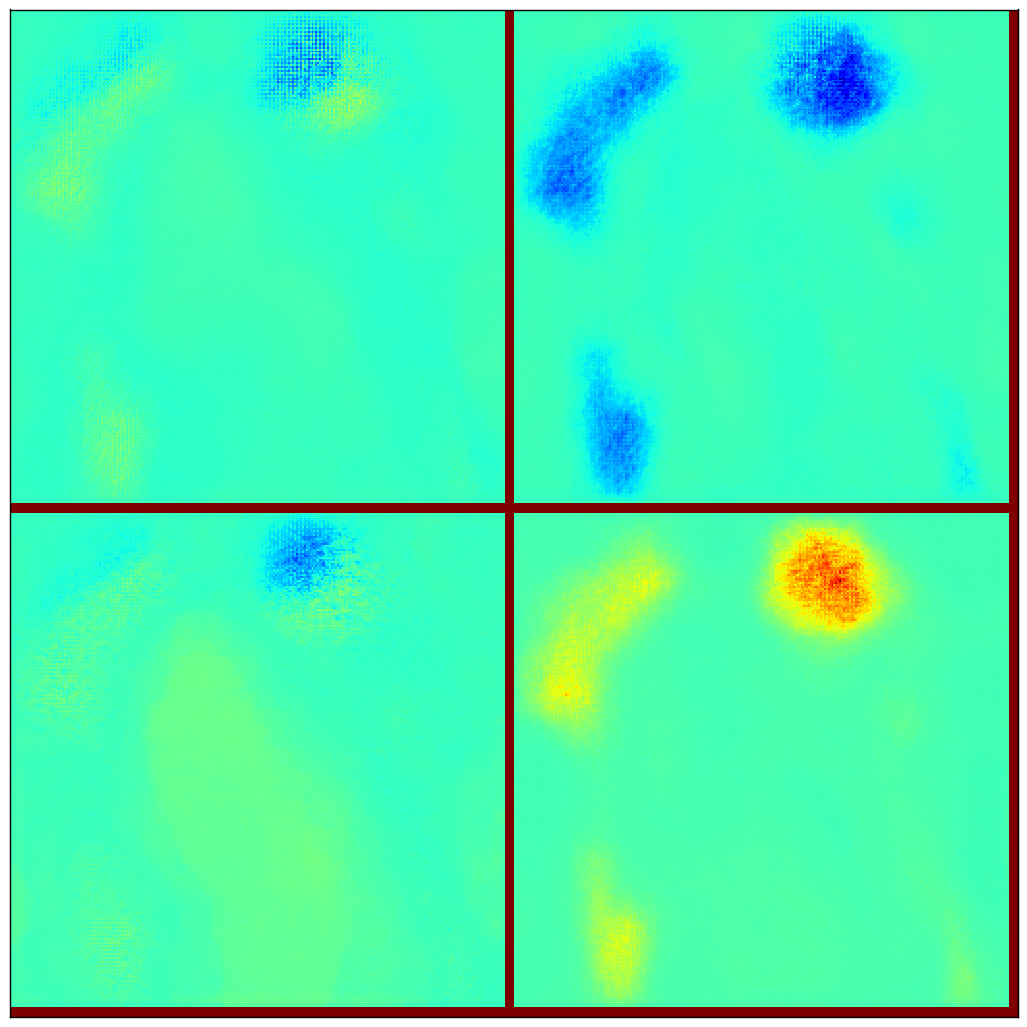

In [56]:
net, index, fig1 = plot_from_net(img_list, net, layer=['conv1_1_D_pca', 'crfrnn', 'prob'], img_index=None)
# fig1.savefig('/home/nathan/histo-seg/semantic-pca/figures/activations/input_result_mask.pdf')

plot_layer = 'crfrnn'
fig2 = plot_filters_activations(net, layer=plot_layer,  mode='a', subset=16)

# plot_layer = 'prob'
# fig3 = plot_filters_activations(net, layer=plot_layer,  mode='a', subset=4)
# fig2.savefig('/home/nathan/histo-seg/semantic-pca/figures/activations/{}.pdf'.format(plot_layer))

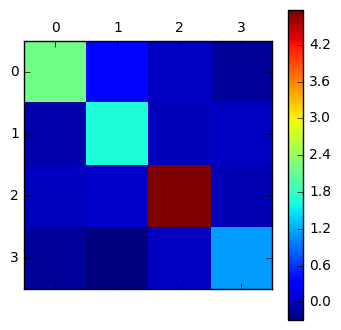

In [28]:
plt.matshow(np.squeeze(net.params['crfrnn'][1].data))
plt.colorbar()

# Fix mask labels

In [43]:
label_levels = {29: 2, 76: 0, 149: 1, 178: 3}

for msk in mask_list:
    mask = cv2.imread(msk, 0)
    mask = replace_eric_labels(mask, label_levels)
    cv2.imwrite(msk, mask)

print 'Done'

Done


(1640, 2988) 0 255
83
9


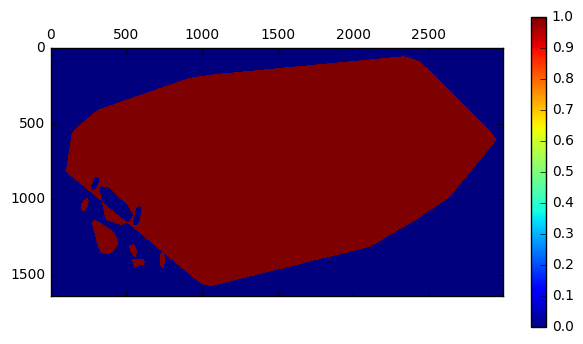

In [18]:
img = cv2.imread('/home/nathan/histo-seg/semantic-pca/analysis_wsi/segnet_basic/1304700_tissue.png', -1)
print img.shape, img.min(), img.max()

cnts, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print len(cnts)
# cnts = [cnt for cnt in cnts if cv2.contourArea(cnt) > 2000]
# print len(cnts)
hulls = [cv2.convexHull(cnt) for cnt in cnts if cv2.contourArea(cnt) > 2000]
print len(hulls)

img2 = np.zeros_like(img)
cv2.drawContours(img2, hulls, -1, (1), -1)

plt.matshow(img2)
plt.colorbar()